# Teoria

Sposób generowania zmiennej  $X\sim S_\alpha(1,\beta,0)$

Algorytm
1. Generuj $V\sim \mathcal{U}\left(-\frac{\pi}{2},\frac{\pi}{2}\right)$
1. Generuj $W\sim \mathcal{E}xp\left(1\right)$
1. Wstaw
    2. dla $\alpha \neq 1$
    $$ X=S_{\alpha,\beta}\frac{\sin\left\{\alpha\left(V+B_{\alpha,\beta}\right)\right\}}{\left\{\cos\left(V\right)\right\}^{1/\alpha}}\left[ \frac{\cos\left\{V-\alpha\left(V+B_{\alpha,\beta}\right)\right\}}{W} \right]^{\left(1-\alpha\right)/\alpha},$$
    gdzie
       $$B_{\alpha,\beta}=\frac{\arctan\left(\beta\tan\frac{\pi\alpha}{2}\right)}{\alpha},$$
       $$ S_{\alpha,\beta} = \left\{1+\beta^2\tan^2\left(\frac{\pi\alpha}{2}\right)\right)^{1/(2\alpha)};$$
    2. dla $\alpha = 1$ 
    $$ X = \frac{2}{\pi}\left\{\left(\frac{\pi}{2}+\beta V\right)\tan V-\beta\ln\left(\frac{\frac{\pi}{2}W\cos V}{\frac{\pi}{2}+\beta V}\right)\right\}$$

Jeśli chcemy obliczyć $Y\sim S_\alpha(\sigma,\beta,\mu)$ wstawiamy
$$
Y=\begin{align}
\begin{cases}
\sigma X+\mu&\alpha\neq1\\
\sigma X + \frac{2}{\pi}\beta\sigma\ln\sigma+\mu&\alpha = 1\\
\end{cases}
\end{align}
$$

W naszym przypatku $\beta=1$ oraz $\mu=0$, zatem powyższe wzory upraszczają się do

$$
Z=\begin{align}
\begin{cases}
\Delta_t^{1/\alpha}\dfrac{\sin\left(\alpha V\right)}{\left(\cos V\right)^{1/\alpha}}\left[ \dfrac{\cos\left\{\left(1-\alpha\right)V\right\}}{W} \right]^{\left(1-\alpha\right)/\alpha}
&\alpha\neq 1\\
\\
\Delta_t^{1/\alpha}\tan V
&\alpha=1\\
\end{cases}
\end{align}
$$

# Generowanie w ogólnym przypadku

## Kod

In [8]:
using Distributions

In [352]:
Alpha_stable_process(;α=1,β=0,μ=0,T=10,Δ=0.01)=begin
    local X
    σ=Δ^(1/α)
    n=round(Int,T/Δ)
    V=rand(Uniform(-π/2,π/2),n)
    W=rand(Exponential(1),n)
    if α==1
        X=@. 2/π*((π/2+β*V)*tan(V) - β*log((π/2*W*cos(V))/(π/2+β*V)))
    elseif 0<α<=2
        S=(1+β^2*tan(π*α/2)^2)^1/(2α)
        B=atan(β*tan(π*α/2))/α
        #println(minimum(@. cos(V-α*(V+B))))
        #return @.(V-α*(V+B))
        X=@. S*(sin(α*(V+B))/(cos(V)^(1/α))) * (cos(V-α*(V+B))/W)^((1-α)/α)
    else
        error("α musi być w przedziale (0,2]")
    end
    
    @. α==1 ? σ*X+2/π*β*log(σ)+μ : σ*X+μ
end

Alpha_stable_process (generic function with 6 methods)

## Wykres

In [418]:
using Plots
plot();

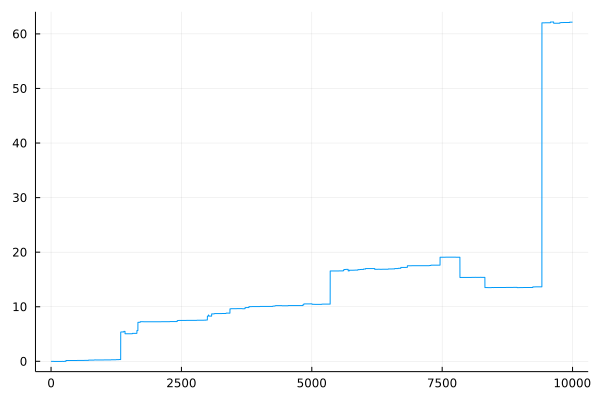

In [725]:
temp=cumsum(Alpha_stable_process(α=1/2,β=1/2,Δ=1e-3));
plot(temp,leg=false)

# Nasz przypadek

## Kod

In [419]:
using Distributions

In [708]:
Exit_time(;α=2,x=1/2,a=0,b=1,Δ=0.01,mode=:all)=begin
    X=x/Δ^(1/α)
    a′=a/Δ^(1/α)
    b′=b/Δ^(1/α)
    if α==1
        t=0
        while a′<X<b′
            X+=tan(rand(Uniform(-π/2,π/2)))
            t+=1
        end
        return  mode==:all  ? (t*Δ, X>=b′) :
                mode==:time ? Δ*t :
                mode==:way  ? X>=b′ :
                nothing
    elseif 0<α<=2
        t=0
        while a′<X<b′
            v=rand(Uniform(-π/2,π/2))
            w=rand(Exponential(1))
            X+=sin(α*v)/(cos(v)^(1/α))*(cos((1-α)*v)/w)^((1-α)/α)/√2
            t+=1
        end
        return  mode==:all  ? (t*Δ, X>=b′) :
                mode==:time ? Δ*t :
                mode==:way  ? X>=b′ :
                nothing
    end
end

Exit_time (generic function with 1 method)

## Obliczenia

In [739]:
using Base
using JLD2

In [890]:
calc(;α,Δ,N,x)=[imp  for j in 1:N for imp in Exit_time(α=α, Δ=Δ, x=x)]

calc (generic function with 1 method)

In [1210]:
on = :PC
t=time()
steps=40
#A=2/steps:2/steps:2
N=1e6
Δ=2e-5
M=60
x=LinRange(0,1,M)

N=Int(N)
M=Int(M)
#File["keys/A"]=As
#File["keys/N"]=N
#File["keys/M"]=M
#File["keys/x"]=x
#File["keys/D"]=Δ

A = on==:PC ? (2/steps:2/steps:1) : (1+2/steps:2/steps:2)

for k in 1:length(A)
    α=A[k]
    Res=zeros(2,M)
    Threads.@threads for i in 1:M
        Temp=calc(α=α, Δ=Δ, x=x[i],N=N)
        Temp=reshape(Temp,(2,N))
        Res[:,i]=mean.(Temp[j,:] for j in 1:2)
    end
    File=jldopen("data/$(round(Int,α*100)).jld","w")
    File["a"]=α
    File["time"]=Res[1,:]
    File["out"]=Res[2,:]
    close(File)
end
time()-t

9.782000064849854

## Śmieci

In [1031]:
File=jldopen("test1.jld","r")

JLDFile D:\GitHub\Symulacje\Sprawko_2_more\Zad 2 more\test1.jld (read-only)
 ├─🔢 a1
 ├─🔢 time1
 ├─🔢 out1
 ├─🔢 a2
 ├─🔢 time2
 ├─🔢 out2
 ├─🔢 a3
 ├─🔢 time3
 ├─🔢 out3
 └─ ⋯ (112 more entries)

In [1028]:
close(File)

In [983]:
length(File["keys/A"])

10

In [1032]:
anim = @animate for i in 1:length(File["keys/A"])
    plot(File["time$i"],leg=false,title="α=$(File["a$i"])")
end

Animation("C:\\Users\\Kacper\\AppData\\Local\\Temp\\jl_5dvfep", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000031.png", "000032.png", "000033.png", "000034.png", "000035.png", "000036.png", "000037.png", "000038.png", "000039.png", "000040.png"])

┌ Info: Saved animation to 
│   fn = D:\GitHub\Symulacje\Sprawko_2_more\Zad 2 more\tmp.gif
└ @ Plots C:\Users\Kacper\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("D:\\GitHub\\Symulacje\\Sprawko_2_more\\Zad 2 more\\tmp.gif")
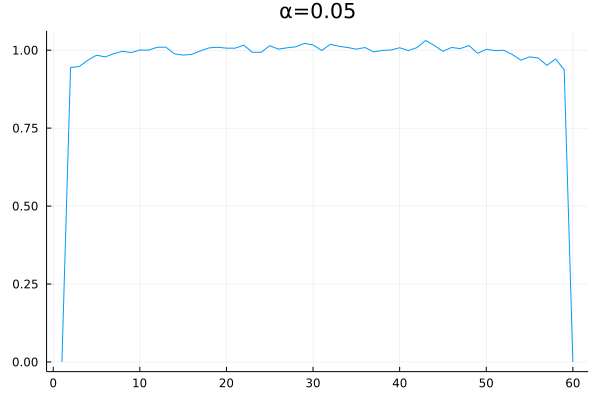

In [1033]:
gif(anim,fps=10)

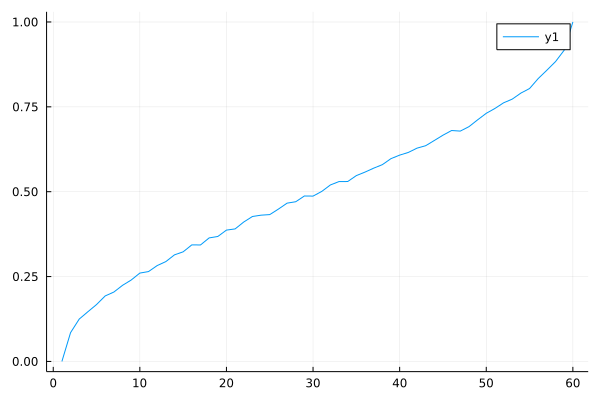

In [1050]:
plot(File["out20"])

In [1091]:
t=time()
steps=40
α=0.11
N=1e3
Δ=1e-5
M=60
x=LinRange(0,1,M)

N=Int(N)
M=Int(M)

Res=zeros(M)
Threads.@threads for i in 1:M
    Res[i]=mean(Exit_time(α=α, Δ=Δ, x=x[i], mode=:way) for j in 1:N)
end
time()-t

53.69199991226196

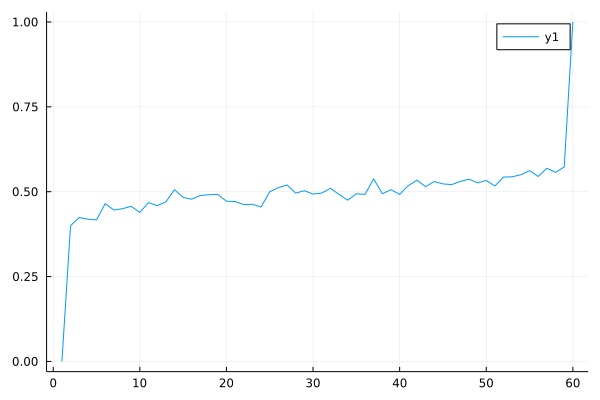

In [1188]:
plot(Res)

In [972]:
close(File)

In [947]:
File=jldopen("Test","r")

JLDFile D:\GitHub\Symulacje\Sprawko_2_more\Zad 2 more\Test (read-only)
 ├─🔢 a1
 ├─🔢 time1
 ├─🔢 out1
 ├─🔢 a2
 ├─🔢 time2
 ├─🔢 out2
 ├─🔢 a3
 ├─🔢 time3
 ├─🔢 out3
 └─📂 keys (5 entries)

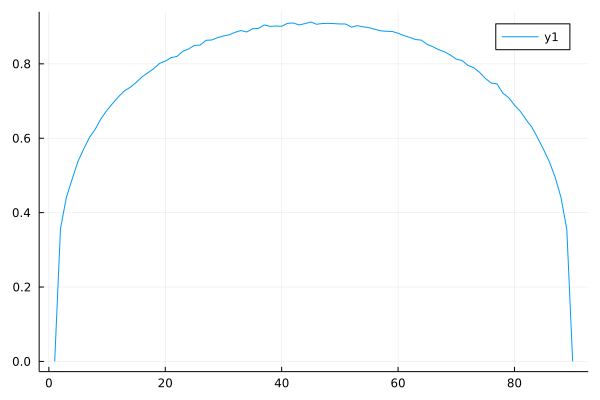

In [971]:
plot(File["time3"])

In [921]:
File["a1"]

0.1

In [922]:
close(File)

In [909]:
Threads.@threads for i in 1:10
    sleep(1)
end

In [870]:
[imp  for j in 1:N for imp in Exit_time(mode=:all, α=1, Δ=Δ, x=1/2)];

In [871]:
reshape(ans,(2,N))

2×100 Matrix{Real}:
     0.34      0.4      0.44      0.74  …      0.09      1.6     0.27
 false     false    false     false        false     false    true

In [ ]:
t=time()
X=LinRange(0,1,100)
Z=zeros(100)
Y=zeros(100)
Threads.@threads for i in 1:100
    res=temp(X[i],n=n,Δ=Δ)
    Y[i]=res[1]
    Z[i]=res[2]
end
time()-t

In [881]:
close(File)

# Test czas

In [451]:
using TimerOutputs
using Distributions

In [514]:
to = TimerOutput();

In [515]:
u=Uniform(-π/2,π/2)
N=1e7
M=Int(1e4)
for i in 1:N
    #@timeit to "rand" π .* rand(M).-π/2 
    @timeit to "uni" rand(Uniform(-π/2,π/2))
    @timeit to "uni u" rand(u)
end

In [516]:
to

 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:      9.63s /  25.4%           1.64GiB /  45.4%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 uni u      10.0M    1.40s   57.5%   140ns    458MiB   60.0%    48.0B
 uni        10.0M    1.04s   42.5%   104ns    305MiB   40.0%    32.0B
 ────────────────────────────────────────────────────────────────────

In [437]:
 
@timeit to "sleep" sleep(0.3)
 

In [ ]:
for i in 1:100
    @timeit to "loop" 1+1
end
 
# Nested sections are possible
@timeit to "nest 1" begin
    @timeit to "nest 2" begin
        @timeit to "nest 3.1" rand(10^3)
        @timeit to "nest 3.2" rand(10^4)
        @timeit to "nest 3.3" rand(10^5)
    end
    rand(10^6)
end

# Śmeci